In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab10.ipynb")

# Lab 10: Climate data and Inference

The first part of the lab accompanies a lecture for Berkeley's Data 100 that covers the fundamental physical mechanisms behind global warming and analyzes CO2 and ocean temperature data. The second part explores correlation, bootstrapping, and confidence intervals of sample statistics.

Climate Authors: Fernando Pérez and [Dr. Chelle Gentemann](https://cgentemann.github.io).

## Due Date
This assignment is due on **April 4th, 2023, at 11:59PM PT**.

## Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

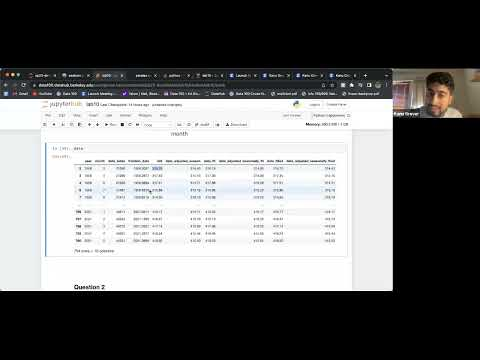

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("5HbGE3JiBzQ")

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your solution.

**Collaborators:** *list names here*

In [3]:
# Run this cell to set up your notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import os


from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part I: Climate

<br><br>

---


## Tutorial: Loading the Mauna Loa CO2 data

We start by loading the same dataset we used during the lecture, containing CO2 measurements in Mauna Loa, Hawaii.

In [4]:
# Set up to load data from the local small copy available in the repo

DATA_DIR = Path('./data')

# If you want to run this on the Berkeley data hub, where we have a larger version of the data,
# uncomment the below. But do not do that for submitting the Lab, as the version that will
# run on the grader needs to use the path above and only has enough data to grade the Lab.
#DATA_DIR = Path.home()/Path('shared/climate-data')

Load the CO2 data from a CSV file:

In [5]:
co2_file = DATA_DIR / "monthly_in_situ_co2_mlo_cleaned.csv"
data = pd.read_csv(co2_file)
data.head()

,year,month,date_index,fraction_date,c02,data_adjusted_season,data_fit,data_adjusted_seasonally_fit,data_filled,data_adjusted_seasonally_filed
0,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71


Remove missing values:

In [6]:
# Remove missing values, which are stored as -99.99.
data = pd.read_csv(co2_file, na_values=-99.99).dropna()
data.head()

,year,month,date_index,fraction_date,c02,data_adjusted_season,data_fit,data_adjusted_seasonally_fit,data_filled,data_adjusted_seasonally_filed
2,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71
6,1958,7,21381,1958.5370,315.86,315.19,315.86,315.22,315.86,315.19
7,1958,8,21412,1958.6219,314.93,316.19,313.99,315.29,314.93,316.19


Let's take a look at what the data looks like!

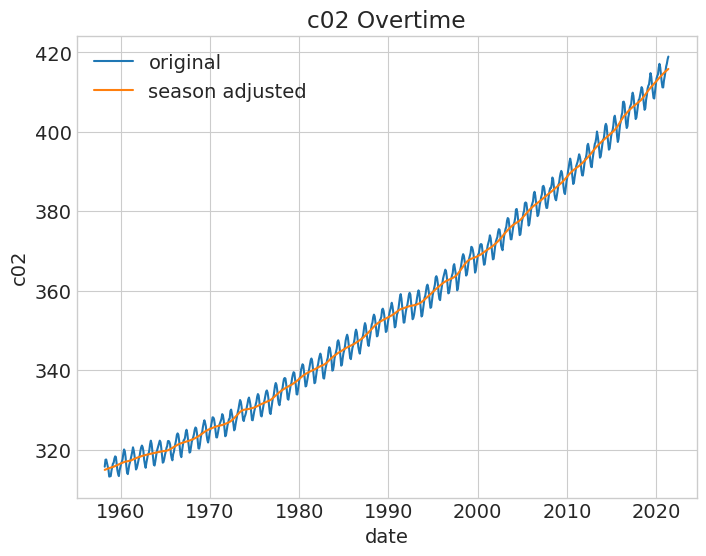

In [7]:
# Let's plot the data
plt.plot("fraction_date", "c02", data=data, label="original")
plt.plot("fraction_date", "data_adjusted_seasonally_fit", data=data, label="season adjusted");
plt.xlabel("date")
plt.ylabel("c02")
plt.legend()
plt.title("c02 Overtime");

<br><br>

---

# Tutorial: Exploring the annual anomaly

Notice how in the plot, there seems to be oscilliations within each year (changing by the months/seasons), but the overall trend of these oscillations appears to be going upward. We are going to try to understand the annual variability on top of the underlying growing trend, and see **whether that variability within a given year is itself changing over time**.

The figure above shows an annual cycle, alongside with perhaps some variability in it. As we saw in lecture (recall the super computer movie in talk with cities release of c02 strongest in winter), plants take up c02 in (northern) spring/summer then release in fall/winter --- so the release is getting stronger. 

The annual cycles look a bit like waves. Recall that the **amplitude** of a wave is the height of its peak. Let's try to estimate the increase in amplitude of annual cycle over time, in years.

In the lecture notebook, we created the following figure, based on a quick and simple `groupby` operation and removal of the **annual mean**:

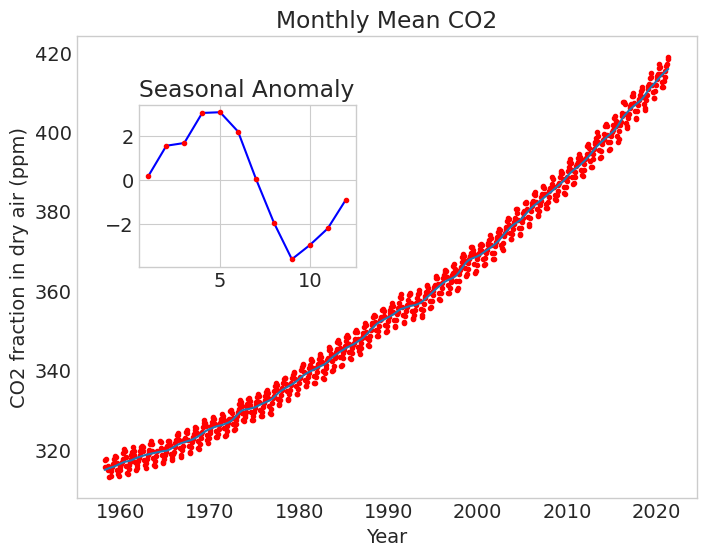

In [8]:
# just run this cell
# Calculate the annual cycle using groupby
annual = data.groupby(data.month).mean()
# Calculate the anomaly
anomaly = annual - annual.mean()

# plot
fig, ax = plt.subplots()

ax.plot("fraction_date", "data_filled", "r.", data=data)
ax.plot("fraction_date", "data_adjusted_seasonally_fit", data=data)
ax.set_xlabel("Year")
ax.set_ylabel("CO2 fraction in dry air (ppm)")
ax.set_title("Monthly Mean CO2")
ax.grid(False)

axin1 = ax.inset_axes([0.1, 0.5, 0.35, 0.35])
axin1.plot(anomaly.c02, "b")
axin1.plot(anomaly.c02, "r.")
axin1.set_title("Seasonal Anomaly");

But if you look closely, that figure isn't quite the same as the one shown in slide 9 of the lecture:

<img src="images/annual-anomaly-orig.png" width="500px" />

We'll start by trying to understand the monthly data. The following shows us the data for all the years, by month:

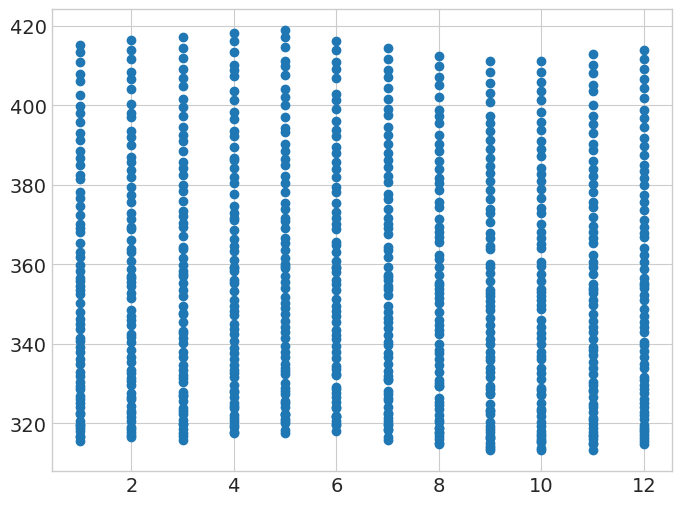

In [9]:
plt.scatter('month', 'c02', data=data);

Unfortunately it's hard to see what's actually going on here. Let's explore this analysis further.

<br><br>

---

## Question 1

Recreate the following figure that shows the monthly cycle for all the years in the dataset:

**Hint:** Use `sns.lineplot(...)` ([documentation](https://seaborn.pydata.org/generated/seaborn.lineplot.html))

<img src="images/monthly-cycles-co2.png" width="600px" />

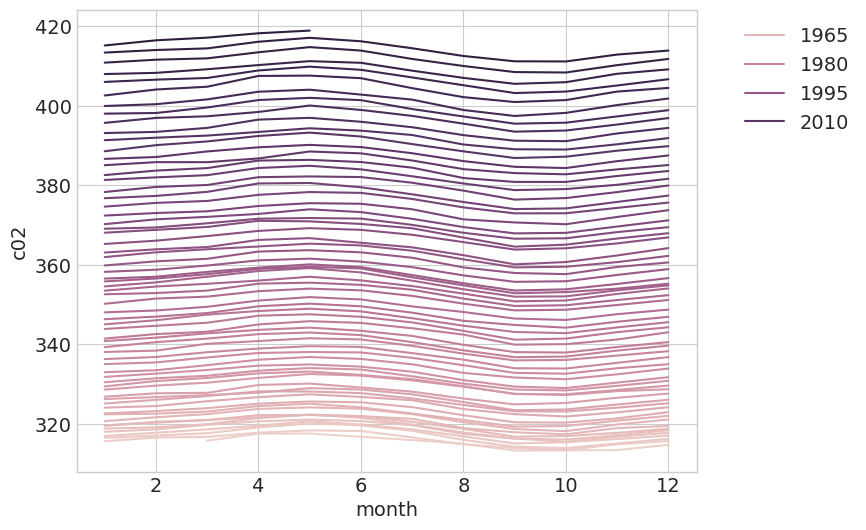

In [10]:
sns.lineplot(data=data, x='month', y='c02', hue='year')
plt.legend(bbox_to_anchor=(1.05,1));

<br><br>

---

## Question 2

Next, in order to attempt to recreate the figure in the talk, we're going to find the monthly anomaly averaging across year. To find this anomaly, we will first be "detrending" our data: we will be taking our data for each year, and subtracting off the mean from that year to get a sense of the variability about the average for each year. After detrending, we'll average the monthly data across all years. In this question, you will be writing code to detrend the data. 

You should end up with the following data frame after calling applying detrend function (only the first five rows are shown):

<img src="images/yearly-co2-anomaly-df.png" width="200px" />

And the following data frame at the end of the cell (only the first five rows are shown):

<img src="images/monthly-co2-anomaly-df.png" width="150px" />


**Hint:** `groupby.apply` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.apply.html)) takes in a subframe, perfrom computation within the subframe, and return a subframe for each group. You should return `"year"`, `"month"`, and the mean-centered `"c02"` for each year. One possible solution involves `pd.concat(..., axis='columns')` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)), take a look at the documentation on how to concatenate multiple columns into a dataframe.

In [12]:
def detrend(df):
    df['c02'] = df['c02']-df['c02'].mean()
    detrended_xarr = df[['year', 'month', 'c02']]

    return detrended_xarr

c02anomaly = data.groupby('year').apply(detrend)
display(c02anomaly)
monthly_anomaly = c02anomaly.groupby('month').mean()[['c02']]
monthly_anomaly

,year,month,c02
2,1958,3,0.3675
3,1958,4,2.1175
4,1958,5,2.1775
6,1958,7,0.5275
7,1958,8,-0.4025
...,...,...,...
756,2021,1,-2.0180
757,2021,2,-0.7180
758,2021,3,-0.0480
759,2021,4,1.0520


,c02
month,
1,-0.683835
2,0.076121
3,0.874238
4,2.240270
5,2.864155
6,2.299297
7,0.792919
8,-1.195018
9,-2.851367


In [13]:
grader.check("q2")

q2 results: All test cases passed!

<br><br>

---

## Question 3

Instead of connected the data points with peice-wise linear line, we will connect the datapoints using cubic spline to smooth the curve. Cubic splines are a very useful method to interpolate data between points (i.e., to draw a function connecting multiple points so we get a better idea of what the function may look like in between points) using a smooth curve. Recreate the following figure, which is much closer to the one in the lecture:

**Hints:**  Use `CubicSpline` from the package `scipy.interpolate` to create the fitted values bewteen the observed datapoints. You can find the documentation for `CubicSpline` [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html). As an extra hint on using `CubicSpline`, its implementation is quite similar to any `sklearn` function you've already used. If you're curious about cubic spline: it is a piece-wise cubic function that not only passes through all datapoints but also has continuous first and second derivatives (more [here](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter17.03-Cubic-Spline-Interpolation.html)).

<img src="images/annual-anomaly-new.png" width="600x" />

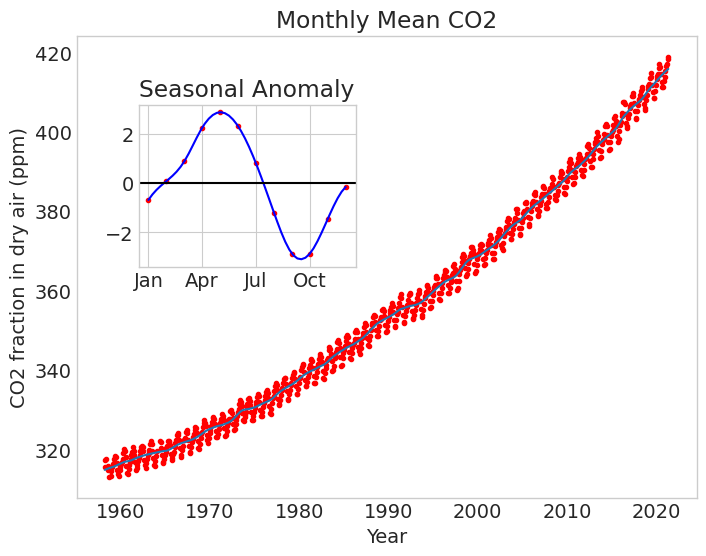

In [14]:
from scipy.interpolate import CubicSpline

# We use plt.subplots to create multiple plots
fig, ax = plt.subplots()

# Plot the main figure
ax.plot("fraction_date", "data_filled", "r.", data=data)
ax.plot("fraction_date", "data_adjusted_seasonally_fit", data=data)
ax.set_xlabel("Year")
ax.set_ylabel("CO2 fraction in dry air (ppm)")
ax.set_title("Monthly Mean CO2")
ax.grid(False)

# Fit a CubicSpline on the original data
interp_model = CubicSpline(monthly_anomaly.index, monthly_anomaly['c02'])
# Define the points that we want to interpolate on
mon_smooth = np.linspace(1,12,50)
# `Predict` aka interpolate on these points
c02_smooth = interp_model(mon_smooth)

# Plot the subfigure on the top left corner
axin1 = ax.inset_axes([0.1, 0.5, 0.35, 0.35])
# Plot the original data as red dots "r."
axin1.plot(monthly_anomaly.index, monthly_anomaly["c02"], "r.")
# Plot the interpolated values as a blue line
axin1.plot(mon_smooth, c02_smooth, "b")
axin1.axhline(color='black')
axin1.set_xticks([1, 4, 7, 10])
axin1.set_xticklabels(['Jan', 'Apr', 'Jul', 'Oct'])
axin1.set_title("Seasonal Anomaly");

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 2: Inference for the Population Correlation

In the previous lab we explored some properties of random variable and identity a biased estimator. For these parts, we assumed we had access to the population data. We simulate samples from the **true population** and calculate mean and varaince of these sample statistics. In practice, however, we only have access to one sample (and therefore one value of our estimator); we will explore this next.


We define **population correlation** as the expected product of *standardized* deviations from expectation: 

$$r(X, Y) =  \mathbb{E} \left[\left(\frac{X - \mathbb{E}[X]}{\text{SD}(X)} \right) \left(\frac{Y - \mathbb{E}[Y]}{\text{SD}(Y)}\right)\right]$$

Note that population correlation involves the population means $\mathbb{E}[X]$ and $\mathbb{E}[Y]$ and the population standard deviations $\text{SD}(X)$ and $\text{SD}(Y)$. Correlation provides us with important information about the linear relationship between variables.

In this part, we'll explore the `tips` dataset once more, and we will compute the sample correlation statistic of two features: **total bill** and **party size**. We will then explore how the sample correlation estimates the true population correlation parameter.

The below cell assigns `data` to our single sample collected about customer tipping behaviors.

In [15]:
# Run this cell to load tips data
tips = sns.load_dataset("tips")
data = tips[['total_bill','size']]
data

,total_bill,size
0,16.99,2
1,10.34,3
2,21.01,3
3,23.68,2
4,24.59,4
...,...,...
239,29.03,3
240,27.18,2
241,22.67,2
242,17.82,2


<br><br>

---

## Question 4
To estimate the population correlation, we'd like to use an estimator based on data from a simple random sample of our tips data set. For a sample $(X_1, Y_1), \dots, (X_n, Y_n)$ generated IID from a population,  define the **sample correlation** as follows:

$$\frac{\sum\limits_{i=1}^n\left(X_i-\overline{X}\right)\left(Y_i-\overline{Y}\right)}{\sqrt{\sum\limits_{i=1}^n \left(X_i - \overline{X}\right)^2}\sqrt{\sum\limits_{i=1}^n \left(Y_i - \overline{Y}\right)^2}}$$

Note the similar structure to the true population correlation. If the $i$-th individual in our sample has "total bill" $X_i$ and "party size" $Y_i$, then $\overline{X}, \overline{Y}$ are the sample means of total bill and party size, respectively.

Implement the `sample_correlation` function in the cell below to compute the sample correlation for `sample`, which has two columns: `total_bill` and `size`.


In [25]:
def sample_correlation(sample):
    """
    Compute sample correlation of x and y.
    sample: A DataFrame of dimension (n, 2). The two columns are 'total_bill' and 'size'
    """
    x, y = sample['total_bill'], sample['size']
    x_bar = x.mean()
    y_bar = y.mean()
    n = len(sample)
    return np.sum((x-x_bar)*(y-y_bar)) / (np.sqrt(np.sum((x-x_bar)**2))*np.sqrt(np.sum((y-y_bar)**2)))

sample_correlation(data)

0.5983151309049014

In [26]:
grader.check("q4")

q4 results: All test cases passed!

### Review: Terminology

Let the sample correlation of `data` be the estimator for the population correlation. In other words:

* **Parameter**: Population correlation. Unknown, but fixed.
* **Statistic**: Sample correlation. Dependent on the random sample we obtained.
* **Estimator**: The sample correlation statistic `corr_est` is an estimator of the population correlation parameter.

What can we infer about the population correlation given this estimate? Is it possible that the total bill and the party size are actually uncorrelated?

We can perform **bootstrapped hypothesis testing** ([data 8 textbook](https://inferentialthinking.com/chapters/13/2/Bootstrap.html)): We cannot simulate samples from the true population, what if we resample from the sample instead? If the sample is representative of the true population, then the resample will also be similar to samples from the original population. Note that if your sample is not representative, boostrapping will also give you a bias result.

The hypothesis are as follows:

* **Null hypothesis**: Total bill and party size are uncorrelated; the population correlation is 0.
* **Alternate hypothesis**: The population correlation is not 0.


To test this hypothesis, we can bootstrap a $(1-p)$% confidence interval for the population correlation and check if 0 is in the interval. If 0 is in the interval, the data are consistent with the null hypothesis. If 0 is *not* in the interval, we reject the null hypothesis at the $p$% significance level. For more on the duality of the confidence interval and the p-value, see this [StackExchange discussion](https://stats.stackexchange.com/questions/179902/confidence-interval-p-value-duality-vs-frequentist-interpretation-of-cis). 

<br><br>

---

## Question 5

Implement the `ci_correlation` function in the cell below that returns a bootstrapped confidence interval at the `conf` level. Your bootstrap should resample the `sample` dataframe with replacement `n` times to construct `m` bootstrapped sample correlations using the `sample_correlation` function you implemented in Question 4.

Then, assign `boot_ci` to the bootstrapped 95\% confidence interval for the tips `data` sample.

**Hint:** You may find `np.percentile` helpful.


In [29]:
def ci_correlation(sample, conf, m=5000):
    """Compute a confidence interval for an estimator.
    sample: A DataFrame or Series
    estimator: A function that maps a sample DataFrame to an estimate (number)
    """
    estimates = []
    n = len(sample)
    for j in range(m):
        resample = sample.sample(n, replace=True)
        estimates.append(sample_correlation(resample))
    lower = np.percentile(estimates, (100-conf)/2)
    upper = np.percentile(estimates, 100-(100-conf)/2)
    return (lower, upper)

boot_ci = ci_correlation(data, 95)
boot_ci

(0.5134297302616564, 0.6764039220797478)

In [30]:
grader.check("q5")

q5 results: All test cases passed!

<br><br>

---

## Question 6
Now that we have the bootstrapped 95% confidence interval of the parameter based on a single sample of size 244, let's determine what we can conclude about our population correlation.

Fill in the blanks for the sentence:

> By bootstrapping our sample `data`, our estimate of the population correlation is ________ with a ___ % confidence interval of ________.

_By bootstrapping our sample DATA, our estimate of the population is 0.595 with a 95% confidence interval of (0.513, 0.676)._

<br><br>

---

## Question 7

In the cell below, interpret the statement from the previous question. Can we reject the null hypothesis at the 5% significance level? What can we infer about the relationship between total bill and party size?


_Type your answer here, replacing this text._

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Congratulations! You are finished with Lab 10!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)